# Problem 2: Incorporating CNNs

* Learning Objective: In this problem, you will learn how to deeply understand how Convolutional Neural Networks work by implementing one.
* Provided Code: We provide the skeletons of classes you need to complete. Forward checking and gradient checkings are provided for verifying your implementation as well.
* TODOs: you will implement a Convolutional Layer and a MaxPooling Layer to improve on your classification results in part 1.

In [1]:
from lib.mlp.fully_conn import *
from lib.mlp.layer_utils import *
from lib.mlp.datasets import *
from lib.mlp.train import *
from lib.cnn.layer_utils import *
from lib.cnn.cnn_models import *
from lib.grad_check import *
from lib.optim import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading the data (SVHN)
Run the following code block to download SVHN dataset and load in the properly splitted SVHN data. The script `get_datasets.sh` use `wget` to download the SVHN dataset. If you have a trouble with executing `get_datasets.sh`, you can manually download the dataset and extract files.

In [2]:
!./get_datasets.sh
# !get_datasets.sh for windows users

--2022-02-20 12:19:55--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘data/train_32x32.mat.1’

train_32x32.mat.1   100%[===================>] 173.61M   266KB/s    in 6m 42s  

2022-02-20 12:26:37 (442 KB/s) - ‘data/train_32x32.mat.1’ saved [182040794/182040794]

--2022-02-20 12:26:37--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘data/test_32x32.mat.1’

test_32x32.mat.1    100%[===================>]  61.30M   418KB/s    in 2m 7s   

2022-02-20 12:28:44 (494 KB/s) - ‘data/test_32x32

In [3]:
data = SVHN_data()
for k, v in data.items():
    print ("Name: {} Shape: {}".format(k, v.shape))

Name: data_train Shape: (70000, 32, 32, 3)
Name: labels_train Shape: (70000,)
Name: data_val Shape: (3257, 32, 32, 3)
Name: labels_val Shape: (3257,)
Name: data_test Shape: (26032, 32, 32, 3)
Name: labels_test Shape: (26032,)


## Convolutional Neural Networks

We will use convolutional neural networks to try to improve on the results from Problem 1. Convolutional layers make the assumption that local pixels are more important for prediction than far-away pixels. This allows us to form networks that are robust to small changes in positioning in images.

### Convolutional Layer Output size calculation [2pts]

As you have learned, two important parameters of a convolutional layer are its stride and padding. To warm up, we will need to calculate the output size of a convolutional layer given its stride and padding. To do this, open the `lib/cnn/layer_utils.py` file and fill out the TODO section in the `get_output_size` function in the ConvLayer2D class. 

Implement your function so that it returns the correct size as indicated by the block below.

In [8]:
%reload_ext autoreload

input_image = np.zeros([32, 28, 28, 3]) # a stack of 32 28 by 28 rgb images

in_channels = input_image.shape[-1] #must agree with the last dimension of the input image
k_size = 4 
n_filt = 16

conv_layer = ConvLayer2D(in_channels, k_size, n_filt, stride=2, padding=3)
output_size = conv_layer.get_output_size(input_image.shape) 

print("Received {} and expected [32, 16, 16, 16]".format(output_size))

Received [32, 16, 16, 16] and expected [32, 16, 16, 16]


### Convolutional Layer Forward Pass [5pts]

Now, we will implement the forward pass of a convolutional layer. Fill in the TODO block in the `forward` function of the ConvLayer2D class.

In [128]:
%reload_ext autoreload

# Test the convolutional forward function
input_image = np.linspace(-0.1, 0.4, num=1*8*8*1).reshape([1, 8, 8, 1]) # a single 8 by 8 grayscale image
in_channels, k_size, n_filt = 1, 5, 2

weight_size = k_size*k_size*in_channels*n_filt
bias_size = n_filt



single_conv = ConvLayer2D(in_channels, k_size, n_filt, stride=1, padding=0, name="conv_test")

w = np.linspace(-0.2, 0.2, num=weight_size).reshape(k_size, k_size, in_channels, n_filt)
b = np.linspace(-0.3, 0.3, num=bias_size)

single_conv.params[single_conv.w_name] = w
single_conv.params[single_conv.b_name] = b

out = single_conv.forward(input_image)

print("Received output shape: {}, Expected output shape: (1, 4, 4, 2)".format(out.shape))

correct_out = np.array([[
   [[-0.03874312, 0.57000324],
   [-0.03955296, 0.57081309],
   [-0.04036281, 0.57162293],
   [-0.04117266, 0.57243278]],

  [[-0.0452219, 0.57648202],
   [-0.04603175, 0.57729187],
   [-0.04684159, 0.57810172],
   [-0.04765144, 0.57891156]],

  [[-0.05170068, 0.5829608 ],
   [-0.05251053, 0.58377065],
   [-0.05332038, 0.5845805 ],
   [-0.05413022, 0.58539035]],

  [[-0.05817946, 0.58943959],
   [-0.05898931, 0.59024943],
   [-0.05979916, 0.59105928],
   [-0.06060901, 0.59186913]]]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-8
print ("Difference: ", rel_error(out, correct_out))

(1, 8, 8, 1)
(1, 4, 4, 2)
(1, 8, 8, 1)
(5, 5, 1, 2)
Received output shape: (1, 4, 4, 2), Expected output shape: (1, 4, 4, 2)
Difference:  5.110565335399418e-08


### Conv Layer Backward [5pts]

Now complete the backward pass of a convolutional layer. Fill in the TODO block in the `backward` function of the ConvLayer2D class. Check you results with this code and expect differences of less than 1e-6.

In [151]:
%reload_ext autoreload

# Test the conv backward function
img = np.random.randn(15, 8, 8, 3)
w = np.random.randn(4, 4, 3, 12)
b = np.random.randn(12)
dout = np.random.randn(15, 4, 4, 12)

single_conv = ConvLayer2D(input_channels=3, kernel_size=4, number_filters=12, stride=2, padding=1, name="conv_test")
single_conv.params[single_conv.w_name] = w
single_conv.params[single_conv.b_name] = b

dimg_num = eval_numerical_gradient_array(lambda x: single_conv.forward(img), img, dout)
dw_num = eval_numerical_gradient_array(lambda w: single_conv.forward(img), w, dout)
db_num = eval_numerical_gradient_array(lambda b: single_conv.forward(img), b, dout)

out = single_conv.forward(img)

dimg = single_conv.backward(dout)
dw = single_conv.grads[single_conv.w_name]
db = single_conv.grads[single_conv.b_name]

# The error should be around 1e-8
print("dimg Error: ", rel_error(dimg_num, dimg))
# The errors should be around 1e-8
print("dw Error: ", rel_error(dw_num, dw))
print("db Error: ", rel_error(db_num, db))
# The shapes should be same
print("dimg Shape: ", dimg.shape, img.shape)

dimg Error:  7.589217731409101e-09
dw Error:  1.1359587845571883e-08
db Error:  7.481628645770771e-10
dimg Shape:  (15, 8, 8, 3) (15, 8, 8, 3)


## Max pooling Layer
Now we will implement maxpooling layers, which can help to reduce the image size while preserving the overall structure of the image.

### Forward Pass max pooling [5pts]
Fill out the TODO block in the `forward` function of the MaxPoolingLayer class.

In [229]:
# Test the convolutional forward function
input_image = np.linspace(-0.1, 0.4, num=64).reshape([1, 8, 8, 1]) # a single 8 by 8 grayscale image

maxpool= MaxPoolingLayer(pool_size=4, stride=2, name="maxpool_test")
out = maxpool.forward(input_image)

print("Received output shape: {}, Expected output shape: (1, 3, 3, 1)".format(out.shape))

correct_out = np.array([[
   [[0.11428571],
   [0.13015873],
   [0.14603175]],

  [[0.24126984],
   [0.25714286],
   [0.27301587]],

  [[0.36825397],
   [0.38412698],
   [0.4       ]]]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-8
print ("Difference: ", rel_error(out, correct_out))

Received output shape: (1, 3, 3, 1), Expected output shape: (1, 3, 3, 1)
Difference:  1.8750000280978013e-08


### Backward Pass Max pooling [5pts]
Fill out the `backward` function in the MaxPoolingLayer class.

In [238]:
img = np.random.randn(15, 8, 8, 3)

dout = np.random.randn(15, 3, 3, 3)

maxpool= MaxPoolingLayer(pool_size=4, stride=2, name="maxpool_test")

dimg_num = eval_numerical_gradient_array(lambda x: maxpool.forward(img), img, dout)

out = maxpool.forward(img)
dimg = maxpool.backward(dout)

# The error should be around 1e-8

print("dimg Error: ", rel_error(dimg_num, dimg))
# The shapes should be same
print("dimg Shape: ", dimg.shape, img.shape)

dimg Error:  3.277195382248681e-12
dimg Shape:  (15, 8, 8, 3) (15, 8, 8, 3)


### Test a Small Fully Connected Network [3pts]
Please find the `TestCNN` class in `lib/cnn/cnn_models.py`.
Again you only need to complete few lines of code in the TODO block.
Please design a Convolutional --> Maxpool --> flatten --> fc network where the shapes of parameters match the given shapes.
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively.
Here you only modify the param_name part, the _w, and _b are automatically assigned during network setup.

In [205]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

model = TestCNN()
loss_func = cross_entropy()

B, H, W, iC = 4, 8, 8, 3 #batch, height, width, in_channels
k = 3 #kernel size
oC, Hi, O = 3, 27, 5 # out channels, Hidden Layer input, Output size
std = 0.02
x = np.random.randn(B,H,W,iC)
y = np.random.randint(O, size=B)

print ("Testing initialization ... ")

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
w1_std = abs(model.net.get_params("conv2d_w").std() - std)
b1 = model.net.get_params("conv2d_b").std()
w2_std = abs(model.net.get_params("fc_test1_w").std() - std)
b2 = model.net.get_params("fc_test1_b").std()
###################################################
#                END OF YOUR CODE                 #
###################################################

assert w1_std < std / 10, "First layer weights do not seem right"
assert np.all(b1 == 0), "First layer biases do not seem right"
assert w2_std < std / 10, "Second layer weights do not seem right"
assert np.all(b2 == 0), "Second layer biases do not seem right"
print ("Passed!")

print ("Testing test-time forward pass ... ")
w1 = np.linspace(-0.7, 0.3, num=k*k*iC*oC).reshape(k,k,iC,oC)
w2 = np.linspace(-0.2, 0.2, num=Hi*O).reshape(Hi, O)
b1 = np.linspace(-0.6, 0.2, num=oC)
b2 = np.linspace(-0.9, 0.1, num=O)

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
model.net.assign("conv2d_w", w1)
model.net.assign("conv2d_b", b1)
model.net.assign("fc_test1_w", w2)
model.net.assign("fc_test1_b", b2)
###################################################
#                END OF YOUR CODE                 #
###################################################

feats = np.linspace(-5.5, 4.5, num=B*H*W*iC).reshape(B,H,W,iC)
scores = model.forward(feats)
correct_scores = np.asarray([[-13.85107294, -11.52845818,  -9.20584342,  -6.88322866,  -4.5606139 ],
 [-11.44514171, -10.21200524 , -8.97886878 , -7.74573231 , -6.51259584],
 [ -9.03921048,  -8.89555231 , -8.75189413 , -8.60823596,  -8.46457778],
 [ -6.63327925 , -7.57909937 , -8.52491949 , -9.4707396 , -10.41655972]])
scores_diff = np.sum(np.abs(scores - correct_scores))
assert scores_diff < 1e-6, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the loss ...",)
y = np.asarray([0, 2, 1, 4])
loss = loss_func.forward(scores, y)
dLoss = loss_func.backward()
correct_loss = 4.56046848799693
assert abs(loss - correct_loss) < 1e-10, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the gradients (error should be no larger than 1e-6) ...")
din = model.backward(dLoss)
for layer in model.net.layers:
    if not layer.params:
        continue
    for name in sorted(layer.grads):
        f = lambda _: loss_func.forward(model.forward(feats), y)
        grad_num = eval_numerical_gradient(f, layer.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, layer.grads[name])))

Testing initialization ... 
Passed!
Testing test-time forward pass ... 
Passed!
Testing the loss ...
Passed!
Testing the gradients (error should be no larger than 1e-6) ...
conv2d_b relative error: 3.90e-09
conv2d_w relative error: 9.26e-10
fc_test1_b relative error: 1.33e-10
fc_test1_w relative error: 3.89e-07


### Training the Network [25pts]
In this section, we defined a `SmallConvolutionalNetwork` class for you to fill in the TODO block in `lib/cnn/cnn_models.py`.

Here please design a network with at most two convolutions and two maxpooling layers (you may use less).
You can adjust the parameters for any layer, and include layers other than those listed above that you have implemented.
You are also free to select any optimizer you have implemented (with any learning rate).

Try to find a combination that is able to achieve 88% validation accuracy.

In [206]:
# Arrange the data
data_dict = {
    "data_train": (data["data_train"], data["labels_train"]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

In [207]:
print("Data shape:", data_dict["data_train"][0].shape)
print("Flattened data input size:", np.prod(data["data_train"].shape[1:]))
print("Number of data classes:", max(data['labels_train']) + 1)

Data shape: (70000, 32, 32, 3)
Flattened data input size: 3072
Number of data classes: 10


In [271]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

model = SmallConvolutionalNetwork()
loss_f = cross_entropy()


results = None
#############################################################################
# TODO: Use the train_net function you completed to train a network         #
#############################################################################
optimizer = Adam(model.net, 5e-3)

batch_size = 64
epochs = 15
lr_decay = 0.004995
lr_decay_every = 10

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
results = train_net(data_dict, model, loss_f, optimizer, batch_size, epochs, 
                    lr_decay, lr_decay_every, show_every=10, verbose=True)
opt_params, loss_hist, train_acc_hist, val_acc_hist = results

(Iteration 1 / 16395) loss: 2.302579835314448
(Iteration 11 / 16395) loss: 2.227076247690509
(Iteration 21 / 16395) loss: 2.2957326337374133
(Iteration 31 / 16395) loss: 2.2324010588183745
(Iteration 41 / 16395) loss: 2.1913752370311945
(Iteration 51 / 16395) loss: 2.374634618214378
(Iteration 61 / 16395) loss: 2.2368120190750442
(Iteration 71 / 16395) loss: 2.205198873691521
(Iteration 81 / 16395) loss: 2.202523194013269
(Iteration 91 / 16395) loss: 2.0994013052410265
(Iteration 101 / 16395) loss: 2.0766808144143956
(Iteration 111 / 16395) loss: 2.100110778656785
(Iteration 121 / 16395) loss: 2.022323035001981
(Iteration 131 / 16395) loss: 1.8197432540504341
(Iteration 141 / 16395) loss: 1.746766478339014
(Iteration 151 / 16395) loss: 1.9396412128440501
(Iteration 161 / 16395) loss: 2.0475965983603155
(Iteration 171 / 16395) loss: 1.6047035014522117
(Iteration 181 / 16395) loss: 1.8469188858513688
(Iteration 191 / 16395) loss: 1.819246929620666
(Iteration 201 / 16395) loss: 1.46029157

(Iteration 1651 / 16395) loss: 0.3665026313815276
(Iteration 1661 / 16395) loss: 0.5197296822840971
(Iteration 1671 / 16395) loss: 0.5376969362739831
(Iteration 1681 / 16395) loss: 0.5538813365383801
(Iteration 1691 / 16395) loss: 0.41121169927007767
(Iteration 1701 / 16395) loss: 0.46343487105677583
(Iteration 1711 / 16395) loss: 0.6677173428663741
(Iteration 1721 / 16395) loss: 0.8030080492437848
(Iteration 1731 / 16395) loss: 0.49193188793266807
(Iteration 1741 / 16395) loss: 0.6255201770095813
(Iteration 1751 / 16395) loss: 0.6484463277690932
(Iteration 1761 / 16395) loss: 0.80248654045312
(Iteration 1771 / 16395) loss: 0.735891887523447
(Iteration 1781 / 16395) loss: 0.9300350178137053
(Iteration 1791 / 16395) loss: 0.7748468121250998
(Iteration 1801 / 16395) loss: 0.5474094171817816
(Iteration 1811 / 16395) loss: 0.4487482024508314
(Iteration 1821 / 16395) loss: 0.47471774380406523
(Iteration 1831 / 16395) loss: 0.8236223299968277
(Iteration 1841 / 16395) loss: 0.4511548090200422

(Iteration 3271 / 16395) loss: 0.4182106458900827
(Epoch 3 / 15) Training Accuracy: 0.8746, Validation Accuracy: 0.8587657353392693
(Iteration 3281 / 16395) loss: 0.7163369736242804
(Iteration 3291 / 16395) loss: 0.487474972676747
(Iteration 3301 / 16395) loss: 0.8335255218263181
(Iteration 3311 / 16395) loss: 0.3451841504835945
(Iteration 3321 / 16395) loss: 0.5587797752071904
(Iteration 3331 / 16395) loss: 0.6558042942122588
(Iteration 3341 / 16395) loss: 0.22746819416568814
(Iteration 3351 / 16395) loss: 0.8674047465846335
(Iteration 3361 / 16395) loss: 0.39909439550196457
(Iteration 3371 / 16395) loss: 0.48049370684881
(Iteration 3381 / 16395) loss: 0.1756446548318697
(Iteration 3391 / 16395) loss: 0.6879779829555097
(Iteration 3401 / 16395) loss: 0.35746010228640723
(Iteration 3411 / 16395) loss: 0.7815450479472162
(Iteration 3421 / 16395) loss: 0.51038059764918
(Iteration 3431 / 16395) loss: 0.37961082437466254
(Iteration 3441 / 16395) loss: 0.37480974356577307
(Iteration 3451 / 

(Iteration 4881 / 16395) loss: 0.49100417659123363
(Iteration 4891 / 16395) loss: 0.4686580351163011
(Iteration 4901 / 16395) loss: 0.3114440125998424
(Iteration 4911 / 16395) loss: 0.471088506871381
(Iteration 4921 / 16395) loss: 0.4667448547495351
(Iteration 4931 / 16395) loss: 0.37481702321683463
(Iteration 4941 / 16395) loss: 0.40175771921857684
(Iteration 4951 / 16395) loss: 0.6572882912720461
(Iteration 4961 / 16395) loss: 0.4140015514731389
(Iteration 4971 / 16395) loss: 0.6023658191554437
(Iteration 4981 / 16395) loss: 0.3826751112728891
(Iteration 4991 / 16395) loss: 0.2915899282254164
(Iteration 5001 / 16395) loss: 0.49637540428599464
(Iteration 5011 / 16395) loss: 0.4876020229525407
(Iteration 5021 / 16395) loss: 0.4028736154529094
(Iteration 5031 / 16395) loss: 0.2972973762019554
(Iteration 5041 / 16395) loss: 0.7815812836157227
(Iteration 5051 / 16395) loss: 0.4110409732214987
(Iteration 5061 / 16395) loss: 0.6078801254994068
(Iteration 5071 / 16395) loss: 0.50568645108527

(Iteration 6501 / 16395) loss: 0.6208185904083816
(Iteration 6511 / 16395) loss: 0.3680370413062266
(Iteration 6521 / 16395) loss: 0.37707843460573287
(Iteration 6531 / 16395) loss: 0.6659345771955231
(Iteration 6541 / 16395) loss: 0.5586056221320586
(Iteration 6551 / 16395) loss: 0.4813506256314038
(Epoch 6 / 15) Training Accuracy: 0.903, Validation Accuracy: 0.8771875959471906
(Iteration 6561 / 16395) loss: 0.21337189756270503
(Iteration 6571 / 16395) loss: 0.3525741124713875
(Iteration 6581 / 16395) loss: 0.7287666619857527
(Iteration 6591 / 16395) loss: 0.48377898853301926
(Iteration 6601 / 16395) loss: 0.6398122007491838
(Iteration 6611 / 16395) loss: 0.3658755339838482
(Iteration 6621 / 16395) loss: 0.5720494355122294
(Iteration 6631 / 16395) loss: 0.3332000859680644
(Iteration 6641 / 16395) loss: 0.6329412796986138
(Iteration 6651 / 16395) loss: 0.42137826921337845
(Iteration 6661 / 16395) loss: 0.42815141251571087
(Iteration 6671 / 16395) loss: 0.30970935340813766
(Iteration 66

(Iteration 8101 / 16395) loss: 0.4532280589387563
(Iteration 8111 / 16395) loss: 0.3097306759338862
(Iteration 8121 / 16395) loss: 0.551978134992245
(Iteration 8131 / 16395) loss: 0.3038905959952374
(Iteration 8141 / 16395) loss: 0.3390036610306446
(Iteration 8151 / 16395) loss: 0.3745385442116273
(Iteration 8161 / 16395) loss: 0.37656199344134256
(Iteration 8171 / 16395) loss: 0.39254017717797274
(Iteration 8181 / 16395) loss: 0.22045681229219358
(Iteration 8191 / 16395) loss: 0.6183743624346112
(Iteration 8201 / 16395) loss: 0.4297176450414969
(Iteration 8211 / 16395) loss: 0.603580833249934
(Iteration 8221 / 16395) loss: 0.3067923027817244
(Iteration 8231 / 16395) loss: 0.32938246337608534
(Iteration 8241 / 16395) loss: 0.6066764051681797
(Iteration 8251 / 16395) loss: 0.46372608706103735
(Iteration 8261 / 16395) loss: 0.6222229695866288
(Iteration 8271 / 16395) loss: 0.5064496054656367
(Iteration 8281 / 16395) loss: 0.35588257814893914
(Iteration 8291 / 16395) loss: 0.1873183388246

(Iteration 9721 / 16395) loss: 0.3320018517644091
(Iteration 9731 / 16395) loss: 0.5884917999991981
(Iteration 9741 / 16395) loss: 0.3810146378130942
(Iteration 9751 / 16395) loss: 0.38829207043961955
(Iteration 9761 / 16395) loss: 0.5700480155326699
(Iteration 9771 / 16395) loss: 0.2984498621155976
(Iteration 9781 / 16395) loss: 0.45829402107966394
(Iteration 9791 / 16395) loss: 0.3292675566744244
(Iteration 9801 / 16395) loss: 0.40669364204706016
(Iteration 9811 / 16395) loss: 0.3893587491575091
(Iteration 9821 / 16395) loss: 0.39074394936367607
(Iteration 9831 / 16395) loss: 0.2701464768968196
(Epoch 9 / 15) Training Accuracy: 0.9106285714285715, Validation Accuracy: 0.8741172858458705
(Iteration 9841 / 16395) loss: 0.4581055086042579
(Iteration 9851 / 16395) loss: 0.314066126417858
(Iteration 9861 / 16395) loss: 0.6273576453540729
(Iteration 9871 / 16395) loss: 0.4759392547545289
(Iteration 9881 / 16395) loss: 0.4912188303329919
(Iteration 9891 / 16395) loss: 0.5035286013836107
(It

(Iteration 11291 / 16395) loss: 0.33605823603241985
(Iteration 11301 / 16395) loss: 0.25851209881886084
(Iteration 11311 / 16395) loss: 0.3434538568352212
(Iteration 11321 / 16395) loss: 0.20426298813037522
(Iteration 11331 / 16395) loss: 0.4349366542125182
(Iteration 11341 / 16395) loss: 0.478333366998607
(Iteration 11351 / 16395) loss: 0.32717381599540596
(Iteration 11361 / 16395) loss: 0.3576750358324955
(Iteration 11371 / 16395) loss: 0.24742706941671588
(Iteration 11381 / 16395) loss: 0.33073588467666987
(Iteration 11391 / 16395) loss: 0.30470657089338404
(Iteration 11401 / 16395) loss: 0.33221680221017286
(Iteration 11411 / 16395) loss: 0.23443355923180728
(Iteration 11421 / 16395) loss: 0.5185864011654305
(Iteration 11431 / 16395) loss: 0.5214845153069113
(Iteration 11441 / 16395) loss: 0.5567405991580254
(Iteration 11451 / 16395) loss: 0.4281898861932911
(Iteration 11461 / 16395) loss: 0.5438610529519361
(Iteration 11471 / 16395) loss: 0.7219158912880328
(Iteration 11481 / 1639

(Iteration 12871 / 16395) loss: 0.25767873615880826
(Iteration 12881 / 16395) loss: 0.3887998846951151
(Iteration 12891 / 16395) loss: 0.3180512904066788
(Iteration 12901 / 16395) loss: 0.5290783198411871
(Iteration 12911 / 16395) loss: 0.22751350717520114
(Iteration 12921 / 16395) loss: 0.40422293977451285
(Iteration 12931 / 16395) loss: 0.4432787462353005
(Iteration 12941 / 16395) loss: 0.29645209881054435
(Iteration 12951 / 16395) loss: 0.4183714326546487
(Iteration 12961 / 16395) loss: 0.36076222335514346
(Iteration 12971 / 16395) loss: 0.43187887107196915
(Iteration 12981 / 16395) loss: 0.3004006316449722
(Iteration 12991 / 16395) loss: 0.3465501106841395
(Iteration 13001 / 16395) loss: 0.3970552082462434
(Iteration 13011 / 16395) loss: 0.5670586382329248
(Iteration 13021 / 16395) loss: 0.3137988047496252
(Iteration 13031 / 16395) loss: 0.2782038456156992
(Iteration 13041 / 16395) loss: 0.22717149040430215
(Iteration 13051 / 16395) loss: 0.4217516470513845
(Iteration 13061 / 16395

(Iteration 14431 / 16395) loss: 0.3733534626365921
(Iteration 14441 / 16395) loss: 0.2639533410905768
(Iteration 14451 / 16395) loss: 0.26731876444201297
(Iteration 14461 / 16395) loss: 0.5192782933635507
(Iteration 14471 / 16395) loss: 0.6109264517389519
(Iteration 14481 / 16395) loss: 0.3590467576607548
(Iteration 14491 / 16395) loss: 0.20105039728957655
(Iteration 14501 / 16395) loss: 0.5368405902802371
(Iteration 14511 / 16395) loss: 0.38026931612066056
(Iteration 14521 / 16395) loss: 0.4626114663651033
(Iteration 14531 / 16395) loss: 0.30108095768850707
(Iteration 14541 / 16395) loss: 0.2679422101932139
(Iteration 14551 / 16395) loss: 0.2444228178007063
(Iteration 14561 / 16395) loss: 0.3877917305853621
(Iteration 14571 / 16395) loss: 0.5137255916373049
(Iteration 14581 / 16395) loss: 0.28316330841354376
(Iteration 14591 / 16395) loss: 0.5415471448160823
(Iteration 14601 / 16395) loss: 0.3375575752645344
(Iteration 14611 / 16395) loss: 0.3381795551255987
(Iteration 14621 / 16395) 

(Iteration 16011 / 16395) loss: 0.3410897086866671
(Iteration 16021 / 16395) loss: 0.4493067563966894
(Iteration 16031 / 16395) loss: 0.5530569154493612
(Iteration 16041 / 16395) loss: 0.38650081764228406
(Iteration 16051 / 16395) loss: 0.39253296815478783
(Iteration 16061 / 16395) loss: 0.08369979487524237
(Iteration 16071 / 16395) loss: 0.5030225678411295
(Iteration 16081 / 16395) loss: 0.3360341715562725
(Iteration 16091 / 16395) loss: 0.45011561443025866
(Iteration 16101 / 16395) loss: 0.3551539240170244
(Iteration 16111 / 16395) loss: 0.43477564167635047
(Iteration 16121 / 16395) loss: 0.3458462079821781
(Iteration 16131 / 16395) loss: 0.39609062010990737
(Iteration 16141 / 16395) loss: 0.37233665249398556
(Iteration 16151 / 16395) loss: 0.23738952877192043
(Iteration 16161 / 16395) loss: 0.3537123067928074
(Iteration 16171 / 16395) loss: 0.5027438668733493
(Iteration 16181 / 16395) loss: 0.48479615284287864
(Iteration 16191 / 16395) loss: 0.546483008708897
(Iteration 16201 / 1639

Run the code below to generate the training plots.

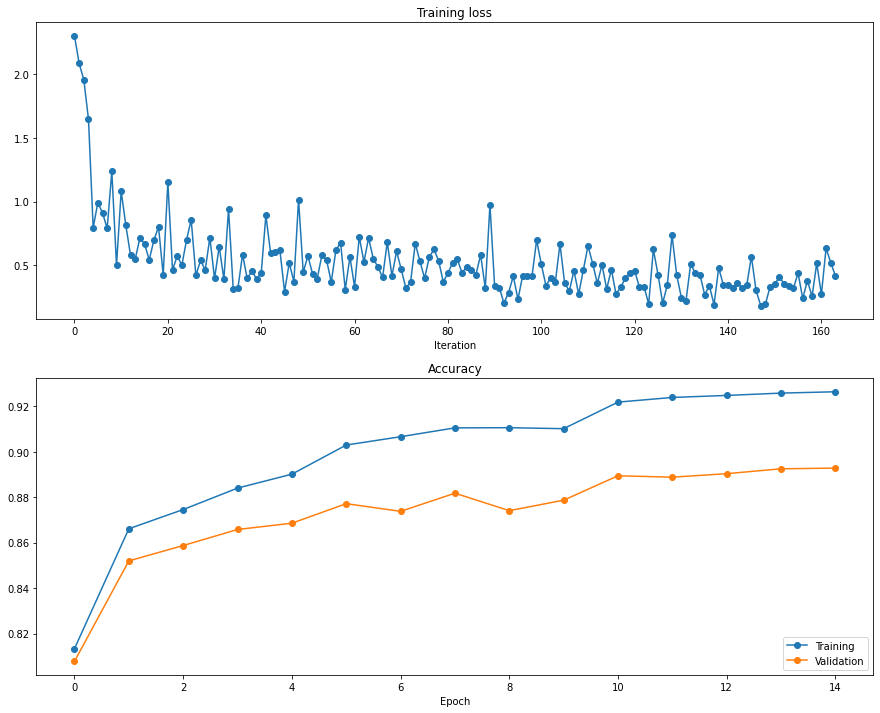

In [272]:
%reload_ext autoreload

opt_params, loss_hist, train_acc_hist, val_acc_hist = results

# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100]  # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.plot(val_acc_hist, '-o', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)

plt.show()

### Visualizing Layers [5pts]

An interesting finding from early research in convolutional networks was that the learned convolutions resembled filters used for things like edge detection. Complete the code below to visualize the filters in the first convolutional layer of your best model.

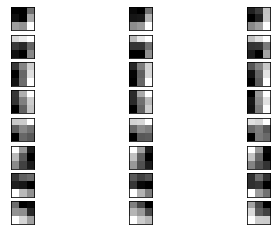

In [285]:
im_array = None
nrows, ncols = None, None

###################################################
# TODO: read the weights in the convolutional     #
# layer and reshape them to a grid of images to   #
# view with matplotlib.                           #
###################################################
filters = model.net.get_params("conv2d1_w")
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_fil, ix = 8, 1
for i in range(n_fil):
    f = filters[:, :, :, i]
    for j in range(3):
        ax = plt.subplot(n_fil, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, j], cmap='gray',)
        ix += 1

###################################################
#                END OF YOUR CODE                 #
###################################################

#plt.imshow(im_array)

#### Inline Question: Comment below on what kinds of filters you see. Include your response in your submission [5pts]

Considered each filter with a depth of 3(RGB), one filter as a plot with 3 images, one for each channel.
The above representation is a filter with size 8 and 3 images. One row for each filter and one column for each channel
The dark squares indicate small weights and the light squares represent large weights
1st fliter focuses on the weights in the bottom right corner of image
2nd filter focuses on top right corner
3rd filter focuses on bottom right vertical rows
4th filter focuses on top right vertical rows
5th filter focuses on horizontal rows
6th filter focuses on left vertical rows
7th filter focuses on bottom horizontal rows
8th filter focuses on bottom left corner

# Submission

Please prepare a PDF document `problem_2_solution.pdf` in the root directory of this repository with all plots and inline answers of your solution. Concretely, the document should contain the following items in strict order:
1. Training loss / accuracy curves for CNN training
2. Visualization of convolutional filters
3. Answers to inline questions about convolutional filters

Note that you still need to submit the jupyter notebook with all generated solutions. We will randomly pick submissions and check that the plots in the PDF and in the notebook are equivalent.